# Optimizing the design and operation of a two-nodal energy system with networks
In this study, we want to look at a two-nodal system in a brownfield manner. We assume two fictous regions with a heat demand and an electricity demand and we want to study the decarbonization of these two regions and the impact of a carbon tax. First, we will optimize the design and operation of the system without a carbon tax and then study the effect of a carbon tax. The topology of the energy system is depicted below. Brown rectangles mean that the technology is already installed, and green rectangles mean that the technology can be newly built. Both colours mean that the technology can be expanded.

We assume that there are two nodes: one depicting a city with no options to install wind turbines and no power plant and a rural node with a gas-fired power plant and the option to install wind turbines.

<div>
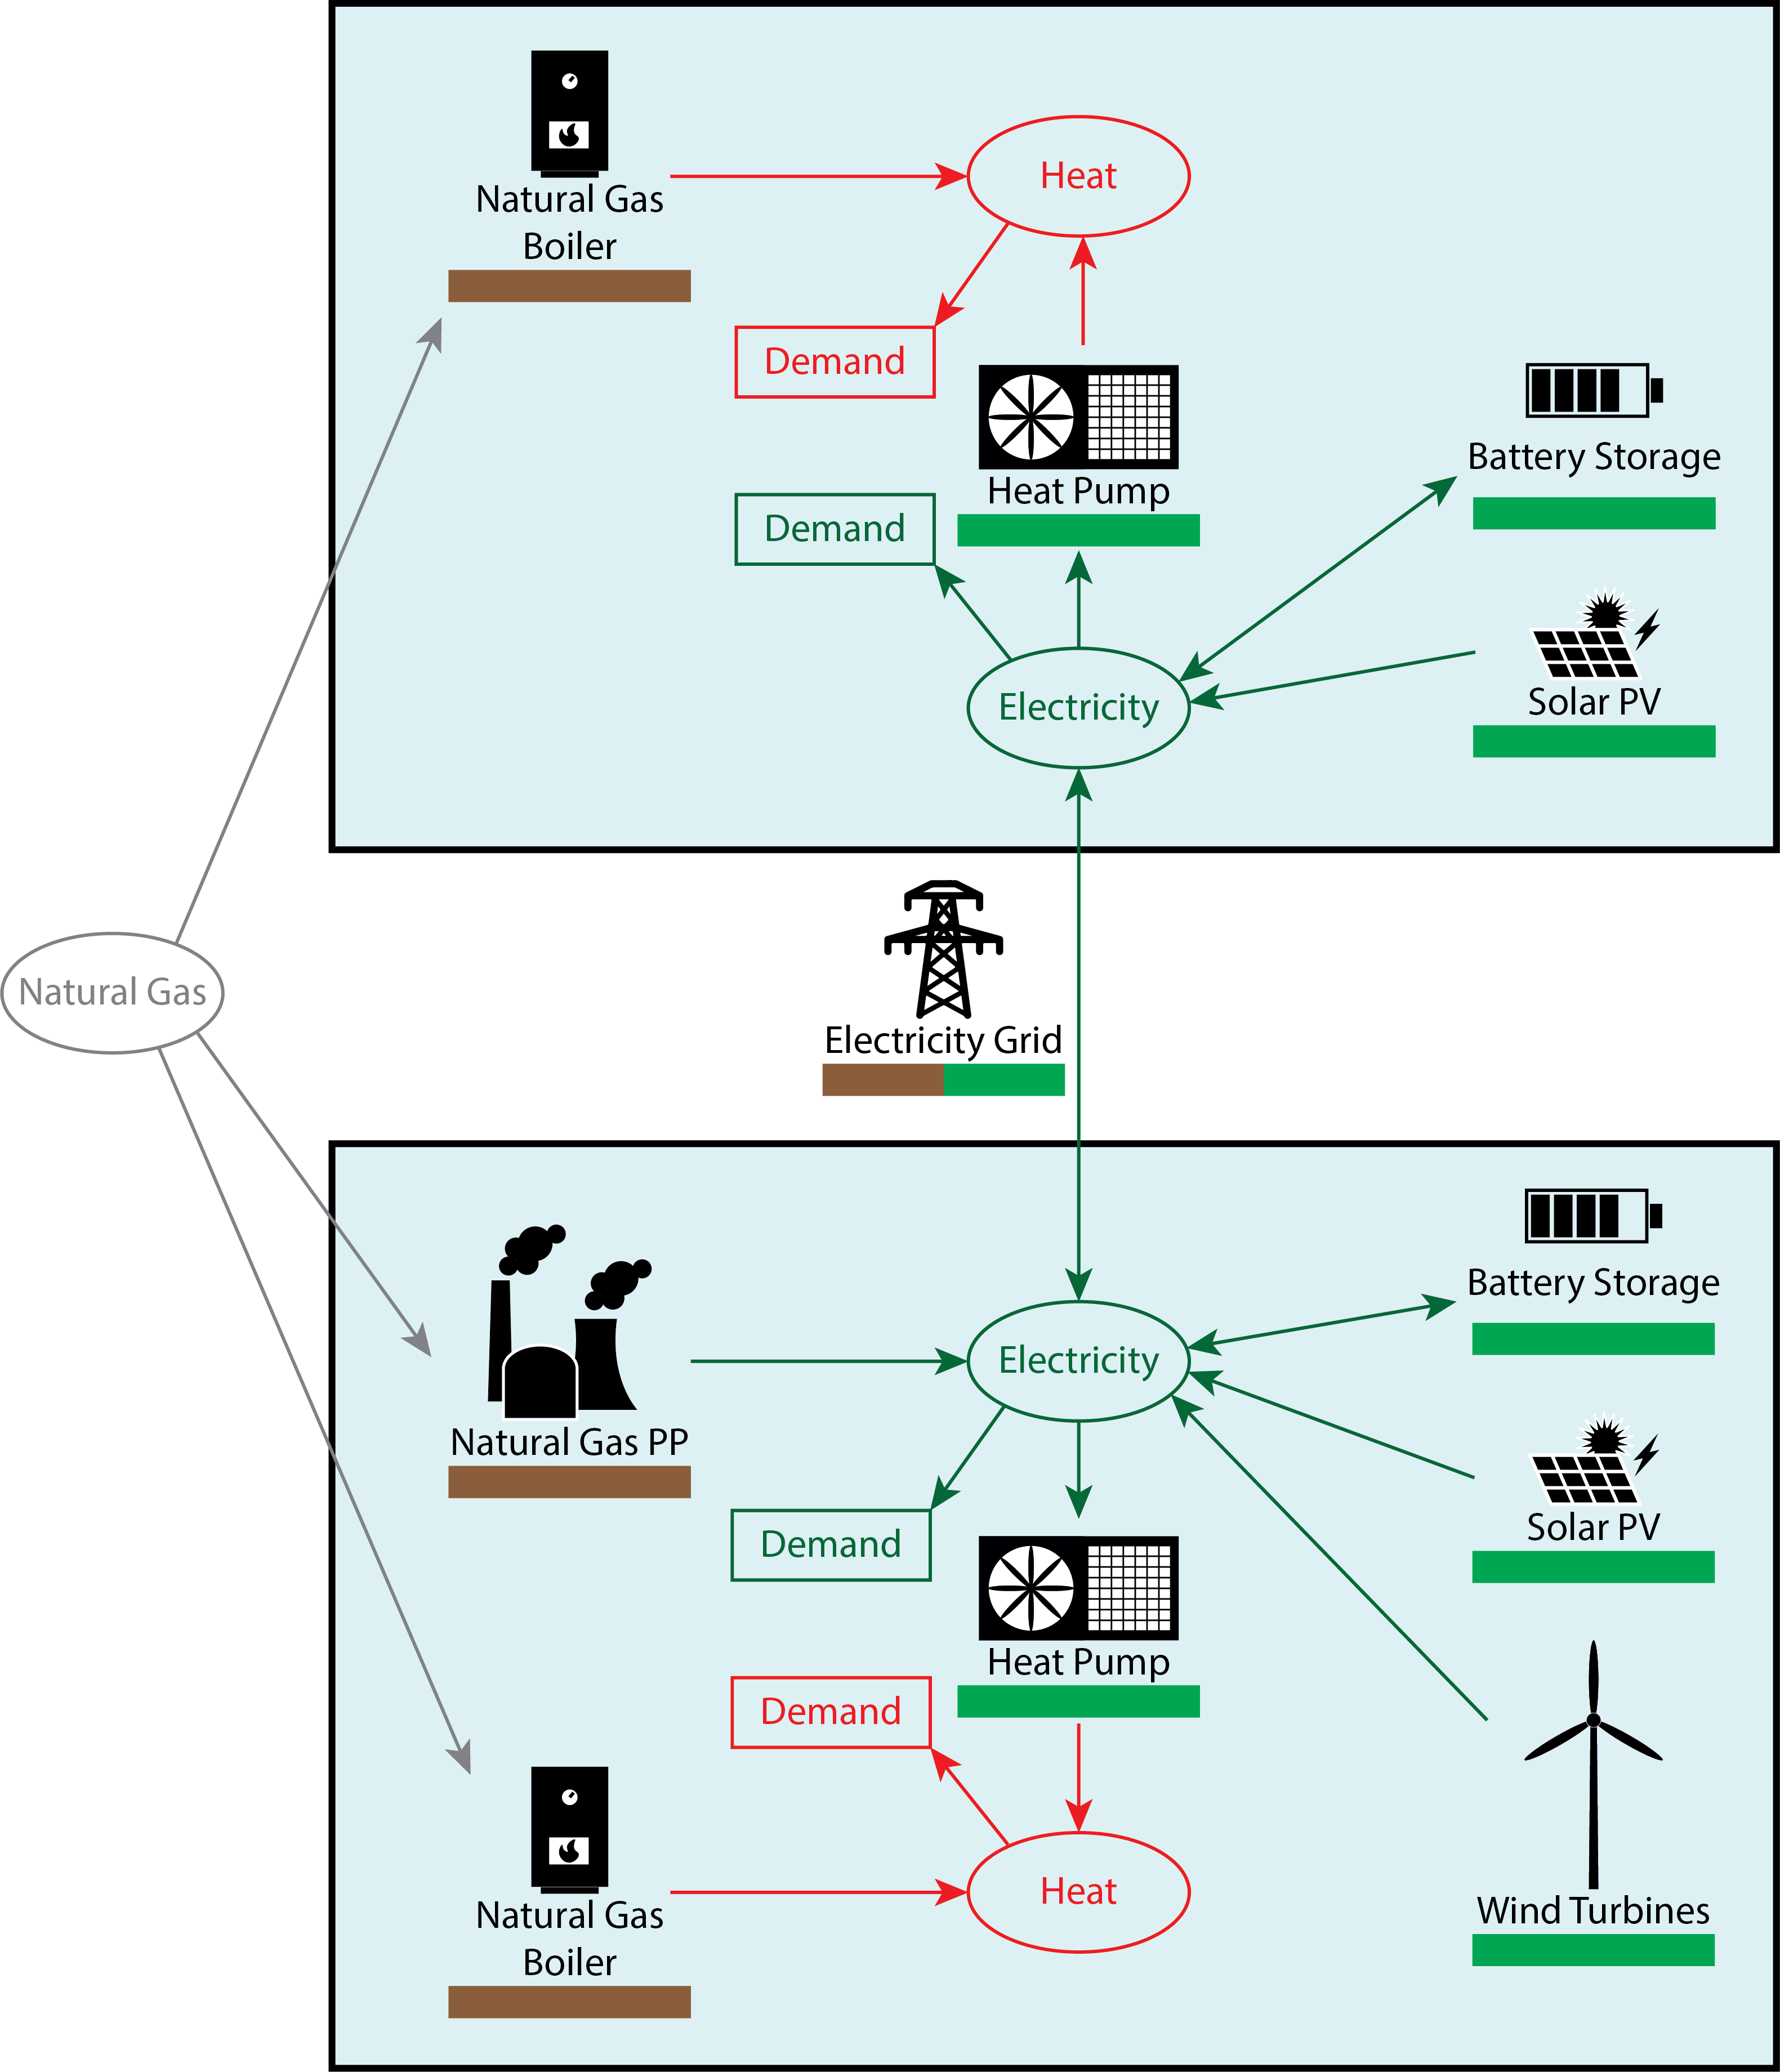
</div>

## Create templates
We set the input data path and in this directory we can add input data templates for the model configuration and the topology with the function create_optimization_templates.


In [1]:
import adopt_net0 as adopt
import json
from pathlib import Path
import os
import pandas as pd
import numpy as np

input_data_path = Path("./caseStudies/network")
adopt.create_optimization_templates(input_data_path)

Files already exist: caseStudies\network\Topology.json caseStudies\network\ConfigModel.json


## Adapt Topology
We need to adapt the topology as well as the model configuration file to our case study. This can be done either in the file itself (Topology.json) or, as we do it here via some lines of code.
For the topology, we need to change the following:
- Change nodes: city and urban area
- Change carriers: electricity, heat and natural gas (we need to add hydrogen as a carrier as well, as the gas turbine also allows for a hydrogen input, even though we do not use it in this case study)
- Change investment periods: period1
- The options regarding the time frame we can leave at the default (one year with hourly operation)

In [2]:
# Load json template
with open(input_data_path / "Topology.json", "r") as json_file:
    topology = json.load(json_file)
# Nodes
topology["nodes"] = ["city", "rural"]
# Carriers:
topology["carriers"] = ["electricity", "heat", "gas", "hydrogen"]
# Investment periods:
topology["investment_periods"] = ["period1"]
# Save json template
with open(input_data_path / "Topology.json", "w") as json_file:
    json.dump(topology, json_file, indent=4)

## Adapt Model Configurations
The model configuration we leave as it is, except spcifying a number of typical days to speed up the optimization (this system also solves on full resolution, but here, we want to only show how the model works at the expense of precision). Additionally, we set the MILP gap to 2%.
- Change the number of typical days to 30 and select time aggregation method 1
- Change the MILP gap to 2%

In [3]:
# Load json template
with open(input_data_path / "ConfigModel.json", "r") as json_file:
    configuration = json.load(json_file)
# Set time aggregation settings:
configuration["optimization"]["typicaldays"]["N"]["value"] = 30
configuration["optimization"]["typicaldays"]["method"]["value"] = 1
# Set MILP gap
configuration["solveroptions"]["mipgap"]["value"] = 0.02
# Save json template
with open(input_data_path / "ConfigModel.json", "w") as json_file:
    json.dump(configuration, json_file, indent=4)

## Define new and existing technologies at each node
First, we create the required folder structure based on the Topology.json file and we can show all available technologies as follows:

In [4]:
adopt.create_input_data_folder_template(input_data_path)
adopt.show_available_technologies()

MEA_large
MEA_medium
MEA_small
DAC_Adsorption
dac_adsorption_performanc
Boiler_El
Boiler_Industrial_NG
Boiler_Small_H2
Boiler_Small_NG
Furnace_H2
Furnace_NG
HeatPump_AirSourced
HeatPump_GroundSourced
HeatPump_WaterSourced
Hydro_Reservoir
PumpedHydro_Closed
PumpedHydro_Open
CrackerFurnace
CrackerFurnace_Electric
EthyleneCompression
EthyleneCompression_Electric
EthyleneSeparation
SteamReformer
SteamReformer_CCS
GasTurbine_H2_10
GasTurbine_H2_100
GasTurbine_H2_250
GasTurbine_H2_400
GasTurbine_NG_10
GasTurbine_NG_100
GasTurbine_NG_250
GasTurbine_NG_400
GasTurbine_simple
GasTurbine_simple_CCS
SteamTurbine
Photovoltaic
SolarThermal
WindTurbine_Offshore_11000
WindTurbine_Offshore_6000
WindTurbine_Offshore_9500
WindTurbine_Onshore_1500
WindTurbine_Onshore_2500
WindTurbine_Onshore_4000
WT_dat
PermanentStorage_CO2_simple
Storage_Battery
Storage_Ethylene
Storage_H2
Storage_H2_Cavern
Storage_HotWater
Storage_NG
Storage_PCM
TemporaryStorage_CO2


... And we can add the technologies that we need to the Technologies.json file at the respective nodes and copy over the required technology data

In [5]:
# Add required technologies for node 'city'
with open(input_data_path / "period1" / "node_data" / "city" / "Technologies.json", "r") as json_file:
    technologies = json.load(json_file)
technologies["new"] = ["HeatPump_AirSourced", "Storage_Battery", "Photovoltaic"]
technologies["existing"] = {"Boiler_Small_NG": 1000}

with open(input_data_path / "period1" / "node_data" / "city" / "Technologies.json", "w") as json_file:
    json.dump(technologies, json_file, indent=4)

# Add required technologies for node 'rural'
with open(input_data_path / "period1" / "node_data" / "rural" / "Technologies.json", "r") as json_file:
    technologies = json.load(json_file)
technologies["new"] = ["HeatPump_AirSourced", "Storage_Battery", "Photovoltaic", "WindTurbine_Onshore_4000"]
technologies["existing"] = {"Boiler_Small_NG": 350, "GasTurbine_simple": 1000}

with open(input_data_path / "period1" / "node_data" / "rural" / "Technologies.json", "w") as json_file:
    json.dump(technologies, json_file, indent=4)

# Copy over technology files
adopt.copy_technology_data(input_data_path)

## Change maximum sizes of heat pumps and boilers
As these technologies are by default set to a household level, we need to change the maximum sizes to make them suitable to meet a larger energy demand

In [6]:
for node in ["city", "rural"]:
    with open(input_data_path / "period1" / "node_data" / node / "technology_data"/ "Boiler_Small_NG.json", "r") as json_file:
        tec_data = json.load(json_file)
        tec_data["size_max"] = 2000

    with open(input_data_path / "period1"  /  "node_data" /node / "technology_data"/ "Boiler_Small_NG.json", "w") as json_file:
        json.dump(tec_data, json_file, indent=4)
    
    with open(input_data_path / "period1" /  "node_data" / node / "technology_data"/ "HeatPump_AirSourced.json", "r") as json_file:
        tec_data = json.load(json_file)
        tec_data["size_max"] = 3000
    with open(input_data_path / "period1" /  "node_data" / node / "technology_data"/ "HeatPump_AirSourced.json", "w") as json_file:
        json.dump(tec_data, json_file, indent=4)
 

## Define the existing and new electricity network between the two nodes
We can see available networks that ship with the model with:

In [7]:
adopt.show_available_networks()

CO2PipelineOffshore
CO2PipelineOnshore
CO2Railway
CO2Ship
CO2Truck
electricityOffshore
electricityOnshore
electricitySimple
heat
hydrogenPipelineOffshore
hydrogenPipelineOnshore
hydrogenRailway
hydrogenShip
hydrogenSimple
hydrogenTruck


In this case, we will use 'electricityOnshore' for both the existing and new network:

In [8]:
# Add networks
with open(input_data_path / "period1" / "Networks.json", "r") as json_file:
    networks = json.load(json_file)
networks["new"] = ["electricityOnshore"]
networks["existing"] = ["electricityOnshore"]

with open(input_data_path / "period1" / "Networks.json", "w") as json_file:
    json.dump(networks, json_file, indent=4)

Now we need to specify the network topologies for both the existing and the new network and copy them in the respective directory. This is easier done manually, but here we do it using Python.
New networks need the following files (size_max_arcs is optional):
- connection.csv (1 or 0)
- distance.csv (distance in km): 50km between the two nodes
  
Existing networks need the following files:
- connection.csv (1 or 0)
- distance.csv (distance in km): 50km between the two nodes
- size.csv (size in MW): 1GW connection

In [9]:
# Make a new folder for the existing network
os.makedirs(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore", exist_ok=True)

print("Existing network")
# Use the templates, fill and save them to the respective directory
# Connection
connection = pd.read_csv(input_data_path / "period1" / "network_topology" / "existing" / "connection.csv", sep=";", index_col=0)
connection.loc["city", "rural"] = 1
connection.loc["rural", "city"] = 1
connection.to_csv(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore" / "connection.csv", sep=";")
print("Connection:", connection)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "existing" / "connection.csv")

# Distance
distance = pd.read_csv(input_data_path / "period1" / "network_topology" / "existing" / "distance.csv", sep=";", index_col=0)
distance.loc["city", "rural"] = 50
distance.loc["rural", "city"] = 50
distance.to_csv(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore" / "distance.csv", sep=";")
print("Distance:", distance)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "existing" / "distance.csv")

# Size
size = pd.read_csv(input_data_path / "period1" / "network_topology" / "existing" / "size.csv", sep=";", index_col=0)
size.loc["city", "rural"] = 1000
size.loc["rural", "city"] = 1000
size.to_csv(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore" / "size.csv", sep=";")
print("Size:", size)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "existing" / "size.csv")

#TODO: remove these 5 lines after bug fixed
# max size arc existing network
arc_size = pd.read_csv(input_data_path / "period1" / "network_topology" / "new" / "size_max_arcs.csv", sep=";", index_col=0)
arc_size.loc["city", "rural"] = 1000
arc_size.loc["rural", "city"] = 1000
arc_size.to_csv(input_data_path / "period1" / "network_topology" / "existing" / "electricityOnshore" / "size_max_arcs.csv", sep=";")
print("Max size per arc:", arc_size)



print("New network")
# Make a new folder for the new network
os.makedirs(input_data_path / "period1" / "network_topology" / "new" / "electricityOnshore", exist_ok=True)


# max size arc
arc_size = pd.read_csv(input_data_path / "period1" / "network_topology" / "new" / "size_max_arcs.csv", sep=";", index_col=0)
arc_size.loc["city", "rural"] = 3000
arc_size.loc["rural", "city"] = 3000
arc_size.to_csv(input_data_path / "period1" / "network_topology" / "new" / "electricityOnshore" / "size_max_arcs.csv", sep=";")
print("Max size per arc:", arc_size)

# Use the templates, fill and save them to the respective directory
# Connection
connection = pd.read_csv(input_data_path / "period1" / "network_topology" / "new" / "connection.csv", sep=";", index_col=0)
connection.loc["city", "rural"] = 1
connection.loc["rural", "city"] = 1
connection.to_csv(input_data_path / "period1" / "network_topology" / "new" / "electricityOnshore" / "connection.csv", sep=";")
print("Connection:", connection)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "new" / "connection.csv")

# Distance
distance = pd.read_csv(input_data_path / "period1" / "network_topology" / "new" / "distance.csv", sep=";", index_col=0)
distance.loc["city", "rural"] = 50
distance.loc["rural", "city"] = 50
distance.to_csv(input_data_path / "period1" / "network_topology" / "new" / "electricityOnshore" / "distance.csv", sep=";")
print("Distance:", distance)

# Delete the template
os.remove(input_data_path / "period1" / "network_topology" / "new" / "distance.csv")

# Delete the max_size_arc template
os.remove(input_data_path / "period1" / "network_topology" / "new" / "size_max_arcs.csv")

Existing network
Connection:        city  rural
city      0      1
rural     1      0
Distance:        city  rural
city      0     50
rural    50      0
Size:        city  rural
city      0   1000
rural  1000      0
Max size per arc:        city  rural
city      0   1000
rural  1000      0
New network
Max size per arc:        city  rural
city      0   3000
rural  3000      0
Connection:        city  rural
city      0      1
rural     1      0
Distance:        city  rural
city      0     50
rural    50      0


## Copy over network data
Copy over network data, change cost data and add location of the two nodes

In [10]:
adopt.copy_network_data(input_data_path)

with open(input_data_path / "period1" / "network_data"/ "electricityOnshore.json", "r") as json_file:
    network_data = json.load(json_file)

network_data["Economics"]["gamma2"] = 40000
network_data["Economics"]["gamma4"] = 300

with open(input_data_path / "period1" / "network_data"/ "electricityOnshore.json", "w") as json_file:
    json.dump(network_data, json_file, indent=4)

node_location = pd.read_csv(input_data_path / "NodeLocations.csv", sep=';', index_col=0, header=0)
node_lon = {'city': 5.1214, 'rural': 5.24}
node_lat = {'city': 52.0907, 'rural': 51.9561}
node_alt = {'city': 5, 'rural': 10}
for node in ['city', 'rural']:
    node_location.at[node, 'lon'] = node_lon[node]
    node_location.at[node, 'lat'] = node_lat[node]
    node_location.at[node, 'alt'] = node_alt[node]

node_location = node_location.reset_index()
node_location.to_csv(input_data_path / "NodeLocations.csv", sep=';', index=False)

## Define demand, climate data, import limits, import prices

In [11]:
# Read hourly data from Excel
user_input_rural_path = "./caseStudies/data/data_network_rural.xlsx"
rural_hourly_data = pd.read_excel(user_input_rural_path, header=0, nrows=8760)
user_input_city_path = "./caseStudies/data/data_network_city.xlsx"
city_hourly_data = pd.read_excel(user_input_city_path, header=0, nrows=8760)

# Save the hourly data to the carrier's file in the case study folder
# electricity demand and price
hourly_data = {
    'city': city_hourly_data,
    'rural': rural_hourly_data
}

el_demand = {}
heat_demand = {}

for node in ['city', 'rural']:
    el_demand[node] = hourly_data[node].iloc[:, 1]
    heat_demand[node] = hourly_data[node].iloc[:, 0]
    adopt.fill_carrier_data(input_data_path, value_or_data=el_demand[node], columns=['Demand'], carriers=['electricity'], nodes=[node])
    adopt.fill_carrier_data(input_data_path, value_or_data=heat_demand[node], columns=['Demand'], carriers=['heat'], nodes=[node])

    # Set import limits/cost
    adopt.fill_carrier_data(input_data_path, value_or_data=4000, columns=['Import limit'], carriers=['gas'], nodes=[node])
    adopt.fill_carrier_data(input_data_path, value_or_data=2000, columns=['Import limit'], carriers=['electricity'], nodes=[node])
    adopt.fill_carrier_data(input_data_path, value_or_data=0.25, columns=['Import emission factor'], carriers=['electricity'], nodes=[node])
    adopt.fill_carrier_data(input_data_path, value_or_data=40, columns=['Import price'], carriers=['gas'], nodes=[node])
    adopt.fill_carrier_data(input_data_path, value_or_data=120, columns=['Import price'], carriers=['electricity'], nodes=[node])

# Define climate data
adopt.load_climate_data_from_api(input_data_path)

Importing Climate Data...
Importing Climate Data successful
Importing Climate Data...
Importing Climate Data successful


## Run without carbon costs

In [12]:
m = adopt.ModelHub()
m.read_data(input_data_path)
m.quick_solve()

INFO:--- Reading in data ---
INFO:Input data folder has been checked successfully - no errors occurred.
INFO:Topology read successfully
INFO:Model Configuration read successfully
INFO:Model Configuration used: {"optimization": {"objective": {"description": "String specifying the objective/type of optimization.", "options": ["costs", "emissions_pos", "emissions_net", "emissions_minC", "costs_emissionlimit", "pareto"], "value": "costs"}, "emission_limit": {"description": "emission limit to be enforced if objective function is costs_emissionlimit", "value": 0}, "monte_carlo": {"N": {"description": "Number of Monte Carlo simulations (0 = off).", "value": 0}, "type": {"description": "Type of Monte Carlo simulation. For type 1 the user defines the standard deviation and the components to vary. For type 2 the user provides a csv file with the parameters and their min, max and reference values. ", "options": ["normal_dis", "uniform_dis_from_file"], "value": "normal_dis"}, "sd": {"description":

--- Reading in data ---
Input data folder has been checked successfully - no errors occurred.
Topology read successfully
Model Configuration read successfully
Found NaN values in data for investment period period1, node city, key1 CarbonCost, carrier global, key2 price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarbonCost, carrier global, key2 subsidy. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.


Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 De

Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Generic production. Replaced with zeros.
F

INFO:Found NaN values in data for investment period period1, node rural, key1 CarbonCost, carrier global, key2 subsidy. Replaced with zeros.


Found NaN values in data for investment period period1, node rural, key1 CarbonCost, carrier global, key2 price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarbonCost, carrier global, key2 subsidy. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node rural, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rur

Found NaN values in data for investment period period1, node rural, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat,

INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Import emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Demand. Replaced with zeros.


Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Demand. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Generic production. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierD

Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Demand. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Export emission factor.

C:\Users\0954659\OneDrive - Universiteit Utrecht\Documents\EHUB-Py\adopt_net0\components\technologies\genericTechnologies\res.py:202: UserWarning: TurbineName not in csv, standard WindTurbine_Onshore_1500 selected.
  warnings.warn(
INFO:Technology data read successfully
INFO:Network data read successfully


Technology data read successfully
Network data read successfully


INFO:Clustered data successfully
INFO:--- Reading in data complete ---
INFO:--- Constructing Model ---
INFO:Constructing Investment Period period1
INFO:Constructing Investment Period period1 completed
INFO:	 - Constructing Network electricityOnshore
INFO:			gdp.bigm Transformation...
INFO:			gdp.bigm Transformation completed in 0 s
INFO:		 - Constructing Arc city - rural completed
INFO:			gdp.bigm Transformation...
INFO:			gdp.bigm Transformation completed in 0 s
INFO:		 - Constructing Arc rural - city completed


Clustered data successfully
--- Reading in data complete ---
--- Constructing Model ---
Constructing Investment Period period1
	 - Constructing Network electricityOnshore
			gdp.bigm Transformation...
			gdp.bigm Transformation...


INFO:	 - Constructing Network electricityOnshore completed
INFO:			gdp.bigm Transformation...
INFO:			gdp.bigm Transformation completed in 0 s


			gdp.bigm Transformation...


INFO:	 - Constructing Network electricityOnshore_existing
INFO:		 - Constructing Arc city - rural completed
INFO:		 - Constructing Arc rural - city completed


	 - Constructing Network electricityOnshore_existing


INFO:	 - Constructing Network electricityOnshore_existing completed
INFO:			gdp.bigm Transformation...
INFO:			gdp.bigm Transformation completed in 0 s


			gdp.bigm Transformation...


INFO:	 - Adding Technology HeatPump_AirSourced
INFO:	 - Adding Technology Storage_Battery


	 - Adding Technology HeatPump_AirSourced
	 - Adding Technology Storage_Battery


INFO:			gdp.bigm Transformation...
INFO:			gdp.bigm Transformation completed in 0 s


			gdp.bigm Transformation...


INFO:	 - Adding Technology Photovoltaic


	 - Adding Technology Photovoltaic


position is deprecated.  Please use at()  (deprecated in 6.1, will be
removed in (or after) 7.0)
(called from C:\Users\0954659\OneDrive - Universiteit Utrecht\Documents\EHUB-Py\adopt_net0\components\technologies\technology.py:905)
INFO:	 - Adding Technology Boiler_Small_NG
INFO:	 - Adding Technology HeatPump_AirSourced
INFO:	 - Adding Technology Storage_Battery


	 - Adding Technology Boiler_Small_NG
	 - Adding Technology HeatPump_AirSourced
	 - Adding Technology Storage_Battery


INFO:			gdp.bigm Transformation...
INFO:			gdp.bigm Transformation completed in 0 s
INFO:	 - Adding Technology Photovoltaic


			gdp.bigm Transformation...
	 - Adding Technology Photovoltaic


INFO:	 - Adding Technology WindTurbine_Onshore_4000
INFO:	 - Adding Technology Boiler_Small_NG


	 - Adding Technology WindTurbine_Onshore_4000
	 - Adding Technology Boiler_Small_NG


INFO:	 - Adding Technology GasTurbine_simple
INFO:Constructing model completed in 4s
INFO:Constructing balances...


	 - Adding Technology GasTurbine_simple
Constructing model completed in 4s
Constructing balances...


INFO:Constructing balances completed in 0s
INFO:Set objective on cost
INFO:Set parameter Username
INFO:Academic license - for non-commercial use only - expires 2025-01-09


Constructing balances completed in 0s
Set objective on cost
____________________________________________________________
Solving Model...
Set parameter LogFile to value "userData\20240624114317-1\solver_log.txt"


INFO:Set parameter LogFile to value "userData\20240624114317-1\solver_log.txt"


Solver log file: userData\20240624114317-1\solver_log.txt
Set parameter TimeLimit to value 36000


INFO:Set parameter TimeLimit to value 36000


Set parameter MIPGap to value 0.02


INFO:Set parameter MIPGap to value 0.02


Set parameter NodefileStart to value 60


INFO:Set parameter NodefileStart to value 60


Set parameter LPWarmStart to value 0


INFO:Set parameter LPWarmStart to value 0


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:


CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]


INFO:CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


INFO:Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


INFO:


Optimize a model with 174814 rows, 148654 columns and 405491 nonzeros


INFO:Optimize a model with 174814 rows, 148654 columns and 405491 nonzeros


Model fingerprint: 0x06947873


INFO:Model fingerprint: 0x06947873


Variable types: 142169 continuous, 6485 integer (5764 binary)


INFO:Variable types: 142169 continuous, 6485 integer (5764 binary)


Coefficient statistics:


INFO:Coefficient statistics:


  Matrix range     [2e-06, 2e+07]


INFO:  Matrix range     [2e-06, 2e+07]


  Objective range  [1e+00, 1e+00]


INFO:  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 8e+11]


INFO:  Bounds range     [1e+00, 8e+11]


  RHS range        [1e+00, 3e+07]


INFO:  RHS range        [1e+00, 3e+07]


INFO:Warning: Model contains large matrix coefficient range


INFO:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:         to avoid numerical issues.


Presolve removed 122560 rows and 117512 columns


INFO:Presolve removed 122560 rows and 117512 columns


Presolve time: 0.31s


INFO:Presolve time: 0.31s


Presolved: 52254 rows, 31142 columns, 152441 nonzeros


INFO:Presolved: 52254 rows, 31142 columns, 152441 nonzeros


Variable types: 27541 continuous, 3601 integer (2881 binary)


INFO:Variable types: 27541 continuous, 3601 integer (2881 binary)


Deterministic concurrent LP optimizer: primal and dual simplex


INFO:Deterministic concurrent LP optimizer: primal and dual simplex


Showing primal log only...


INFO:Showing primal log only...


INFO:


Concurrent spin time: 0.00s


INFO:Concurrent spin time: 0.00s


INFO:


Solved with dual simplex


INFO:Solved with dual simplex


INFO:


Root relaxation: objective 6.099582e+08, 25159 iterations, 3.44 seconds (2.69 work units)


INFO:Root relaxation: objective 6.099582e+08, 25159 iterations, 3.44 seconds (2.69 work units)


INFO:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:


*    0     0               0    6.099582e+08 6.0996e+08  0.00%     -    4s


INFO:*    0     0               0    6.099582e+08 6.0996e+08  0.00%     -    4s


INFO:


Explored 1 nodes (25159 simplex iterations) in 4.69 seconds (3.96 work units)


INFO:Explored 1 nodes (25159 simplex iterations) in 4.69 seconds (3.96 work units)


Thread count was 12 (of 12 available processors)


INFO:Thread count was 12 (of 12 available processors)


INFO:


Solution count 1: 6.09958e+08 


INFO:Solution count 1: 6.09958e+08 


INFO:


Optimal solution found (tolerance 2.00e-02)


INFO:Optimal solution found (tolerance 2.00e-02)


Best objective 6.099582188247e+08, best bound 6.099582188247e+08, gap 0.0000%


INFO:Best objective 6.099582188247e+08, best bound 6.099582188247e+08, gap 0.0000%


Set parameter LogFile to value ""


INFO:Set parameter LogFile to value ""
INFO:Writing results to userData\20240624114317-1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 609958218.8246659
  Upper bound: 609958218.8246675
  Number of objectives: 1
  Number of constraints: 174814
  Number of variables: 148654
  Number of binary variables: 5764
  Number of integer variables: 6485
  Number of continuous variables: 136405
  Number of nonzeros: 405491
  Sense: 1
  Number of solutions: 1
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Name: Gurobi 11.01
  Status: ok
  Wallclock time: 4.698999881744385
  Termination condition: optimal
  Termination message: Model was solved to optimality (su

## First results: technology sizes
The results of the optimizations, which are saved in the userData folder, can be (partially) visualized using the provided visualization platform (https://resultvisualization.streamlit.app/). Here we just report some screenshots, specifically the sizes (all in MW) of the technologies installed in the network. It can be noticed that, in addition to the existing technologies (gas boiler in the city node, gas boiler and gas plant in the rural node), it is cost-efficient to install heat pumps in both nodes and more than 5 GW of PV in the city node. Note that the heat pump sizes seem quite small, but it is given in terms of electricity input, so the heat output needs to be multiplied by the COP.

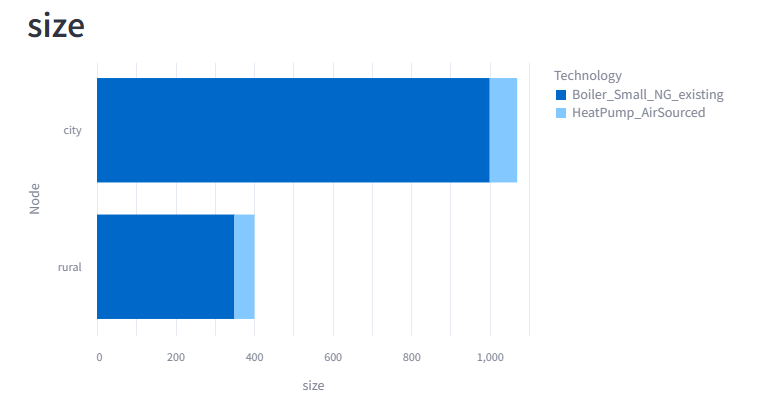

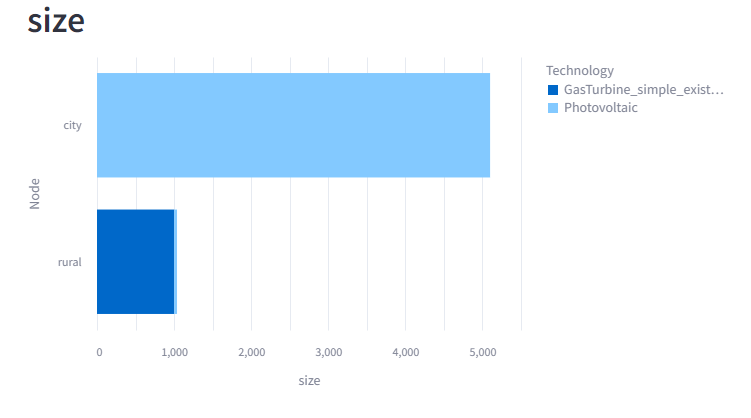



## First results: network
From a network perspective, around 100 MW of transmission capacity has been added to transport electricity from the rural node to the city. In fact, the electricity exchange happens only from the rural to the city node (~1.2 TWh exchanged over 1 year).

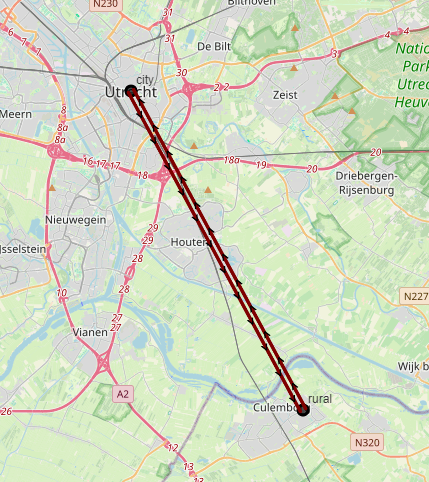

## Run with carbon costs

In [13]:
# Set carbon emission price
carbon_price = np.ones(8760)*100
for node in ["city", "rural"]:
    carbon_cost_path = "./caseStudies/network/period1/node_data/" + node + "/CarbonCost.csv"
    carbon_cost_template = pd.read_csv(carbon_cost_path, sep=';', index_col=0, header=0)
    carbon_cost_template['price'] = carbon_price
    carbon_cost_template = carbon_cost_template.reset_index()
    carbon_cost_template.to_csv(carbon_cost_path, sep=';', index=False)

m = adopt.ModelHub()
m.read_data(input_data_path)
m.quick_solve()

INFO:--- Reading in data ---
INFO:Input data folder has been checked successfully - no errors occurred.
INFO:Topology read successfully
INFO:Model Configuration read successfully
INFO:Model Configuration used: {"optimization": {"objective": {"description": "String specifying the objective/type of optimization.", "options": ["costs", "emissions_pos", "emissions_net", "emissions_minC", "costs_emissionlimit", "pareto"], "value": "costs"}, "emission_limit": {"description": "emission limit to be enforced if objective function is costs_emissionlimit", "value": 0}, "monte_carlo": {"N": {"description": "Number of Monte Carlo simulations (0 = off).", "value": 0}, "type": {"description": "Type of Monte Carlo simulation. For type 1 the user defines the standard deviation and the components to vary. For type 2 the user provides a csv file with the parameters and their min, max and reference values. ", "options": ["normal_dis", "uniform_dis_from_file"], "value": "normal_dis"}, "sd": {"description":

--- Reading in data ---
Input data folder has been checked successfully - no errors occurred.
Topology read successfully
Model Configuration read successfully
Found NaN values in data for investment period period1, node city, key1 CarbonCost, carrier global, key2 subsidy. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.


Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier gas, key2 De

Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier heat, key2 Generic production. Replaced with zeros.
F

INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Import price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Import emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarbonCost, carrier global, key2 subsidy. Replaced with zeros.


Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Import price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node city, key1 CarrierData, carrier hydrogen, key2 Generic production. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node rural, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.


Found NaN values in data for investment period period1, node rural, key1 CarbonCost, carrier global, key2 subsidy. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 ClimateData, carrier global, key2 TECHNOLOGYNAME_hydro_inflow. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier electricity, key2 Generic production. Replaced with zeros.


INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, 

Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier heat, key2 Generic production. Replaced with z

INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export price. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Import emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export emission factor. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Generic production. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Demand. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import limit. Replaced with zeros.
INFO:Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydroge

Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export limit. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export price. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Import emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Export emission factor. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier gas, key2 Generic production. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Demand. Replaced with zeros.
Found NaN values in data for investment period period1, node rural, key1 CarrierData, carrier hydrogen, key2 Import limit. Replaced with zero

INFO:Time series read successfully
INFO:Node Locations read successfully
INFO:Energy balance options read successfully


Time series read successfully
Node Locations read successfully
Energy balance options read successfully
Deriving performance data for Heat Pump...
Complete:  99.0 %Complete:  100 %7.0 %
Deriving performance data for Heat Pump...
Complete:  99.0 %Complete:  100 %


C:\Users\0954659\OneDrive - Universiteit Utrecht\Documents\EHUB-Py\adopt_net0\components\technologies\genericTechnologies\res.py:202: UserWarning: TurbineName not in csv, standard WindTurbine_Onshore_1500 selected.
  warnings.warn(
INFO:Technology data read successfully
INFO:Network data read successfully


Technology data read successfully
Network data read successfully


INFO:Clustered data successfully
INFO:--- Reading in data complete ---
INFO:--- Constructing Model ---
INFO:Constructing Investment Period period1
INFO:Constructing Investment Period period1 completed
INFO:	 - Constructing Network electricityOnshore
INFO:			gdp.bigm Transformation...
INFO:			gdp.bigm Transformation completed in 0 s
INFO:		 - Constructing Arc city - rural completed
INFO:			gdp.bigm Transformation...
INFO:			gdp.bigm Transformation completed in 0 s
INFO:		 - Constructing Arc rural - city completed


Clustered data successfully
--- Reading in data complete ---
--- Constructing Model ---
Constructing Investment Period period1
	 - Constructing Network electricityOnshore
			gdp.bigm Transformation...
			gdp.bigm Transformation...


INFO:	 - Constructing Network electricityOnshore completed
INFO:			gdp.bigm Transformation...


			gdp.bigm Transformation...


INFO:			gdp.bigm Transformation completed in 1 s
INFO:	 - Constructing Network electricityOnshore_existing
INFO:		 - Constructing Arc city - rural completed
INFO:		 - Constructing Arc rural - city completed


	 - Constructing Network electricityOnshore_existing


INFO:	 - Constructing Network electricityOnshore_existing completed
INFO:			gdp.bigm Transformation...


			gdp.bigm Transformation...


INFO:			gdp.bigm Transformation completed in 0 s
INFO:	 - Adding Technology HeatPump_AirSourced
INFO:	 - Adding Technology Storage_Battery


	 - Adding Technology HeatPump_AirSourced
	 - Adding Technology Storage_Battery


INFO:			gdp.bigm Transformation...


			gdp.bigm Transformation...


INFO:			gdp.bigm Transformation completed in 0 s
INFO:	 - Adding Technology Photovoltaic


	 - Adding Technology Photovoltaic


INFO:	 - Adding Technology Boiler_Small_NG
INFO:	 - Adding Technology HeatPump_AirSourced


	 - Adding Technology Boiler_Small_NG
	 - Adding Technology HeatPump_AirSourced


INFO:	 - Adding Technology Storage_Battery


	 - Adding Technology Storage_Battery


INFO:			gdp.bigm Transformation...


			gdp.bigm Transformation...


INFO:			gdp.bigm Transformation completed in 0 s
INFO:	 - Adding Technology Photovoltaic
INFO:	 - Adding Technology WindTurbine_Onshore_4000
INFO:	 - Adding Technology Boiler_Small_NG


	 - Adding Technology Photovoltaic
	 - Adding Technology WindTurbine_Onshore_4000


INFO:	 - Adding Technology GasTurbine_simple
INFO:Constructing model completed in 7s
INFO:Constructing balances...


	 - Adding Technology Boiler_Small_NG
	 - Adding Technology GasTurbine_simple
Constructing model completed in 7s
Constructing balances...


INFO:Constructing balances completed in 0s
INFO:Set objective on cost


Constructing balances completed in 0s
Set objective on cost
____________________________________________________________
Solving Model...
Set parameter LogFile to value "userData\20240624114348-1\solver_log.txt"


INFO:Set parameter LogFile to value "userData\20240624114348-1\solver_log.txt"


Solver log file: userData\20240624114348-1\solver_log.txt
Set parameter TimeLimit to value 36000


INFO:Set parameter TimeLimit to value 36000


Set parameter MIPGap to value 0.02


INFO:Set parameter MIPGap to value 0.02


Set parameter NodefileStart to value 60


INFO:Set parameter NodefileStart to value 60


Set parameter LPWarmStart to value 0


INFO:Set parameter LPWarmStart to value 0


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:


CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]


INFO:CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


INFO:Thread count: 10 physical cores, 12 logical processors, using up to 12 threads


INFO:


Optimize a model with 174814 rows, 148654 columns and 417025 nonzeros


INFO:Optimize a model with 174814 rows, 148654 columns and 417025 nonzeros


Model fingerprint: 0xc2fa3c2c


INFO:Model fingerprint: 0xc2fa3c2c


Variable types: 142169 continuous, 6485 integer (5764 binary)


INFO:Variable types: 142169 continuous, 6485 integer (5764 binary)


Coefficient statistics:


INFO:Coefficient statistics:


  Matrix range     [2e-06, 2e+07]


INFO:  Matrix range     [2e-06, 2e+07]


  Objective range  [1e+00, 1e+00]


INFO:  Objective range  [1e+00, 1e+00]


  Bounds range     [6e-01, 8e+11]


INFO:  Bounds range     [6e-01, 8e+11]


  RHS range        [1e+00, 3e+07]


INFO:  RHS range        [1e+00, 3e+07]


INFO:Warning: Model contains large matrix coefficient range


INFO:Warning: Model contains large bounds


         Consider reformulating model or setting NumericFocus parameter


INFO:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:         to avoid numerical issues.


Presolve removed 122547 rows and 117499 columns


INFO:Presolve removed 122547 rows and 117499 columns


Presolve time: 0.32s


INFO:Presolve time: 0.32s


Presolved: 52267 rows, 31155 columns, 152480 nonzeros


INFO:Presolved: 52267 rows, 31155 columns, 152480 nonzeros


Variable types: 27553 continuous, 3602 integer (2881 binary)


INFO:Variable types: 27553 continuous, 3602 integer (2881 binary)


Deterministic concurrent LP optimizer: primal and dual simplex


INFO:Deterministic concurrent LP optimizer: primal and dual simplex


Showing primal log only...


INFO:Showing primal log only...


INFO:


INFO:


Root simplex log...


INFO:Root simplex log...


INFO:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    7491    1.1593177e+09   0.000000e+00   7.356063e+12      5s


INFO:    7491    1.1593177e+09   0.000000e+00   7.356063e+12      5s


Concurrent spin time: 0.00s


INFO:Concurrent spin time: 0.00s


INFO:


Solved with dual simplex


INFO:Solved with dual simplex


INFO:


Root simplex log...


INFO:Root simplex log...


INFO:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   30332    9.4921442e+08   0.000000e+00   0.000000e+00      7s


INFO:   30332    9.4921442e+08   0.000000e+00   0.000000e+00      7s


INFO:


Root relaxation: objective 9.492144e+08, 30332 iterations, 6.09 seconds (4.36 work units)


INFO:Root relaxation: objective 9.492144e+08, 30332 iterations, 6.09 seconds (4.36 work units)


INFO:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:


*    0     0               0    9.492144e+08 9.4921e+08  0.00%     -    7s


INFO:*    0     0               0    9.492144e+08 9.4921e+08  0.00%     -    7s


INFO:


Explored 1 nodes (30332 simplex iterations) in 7.31 seconds (5.65 work units)


INFO:Explored 1 nodes (30332 simplex iterations) in 7.31 seconds (5.65 work units)


Thread count was 12 (of 12 available processors)


INFO:Thread count was 12 (of 12 available processors)


INFO:


Solution count 1: 9.49214e+08 


INFO:Solution count 1: 9.49214e+08 


INFO:


Optimal solution found (tolerance 2.00e-02)


INFO:Optimal solution found (tolerance 2.00e-02)


Best objective 9.492144237356e+08, best bound 9.492144237356e+08, gap 0.0000%


INFO:Best objective 9.492144237356e+08, best bound 9.492144237356e+08, gap 0.0000%


Set parameter LogFile to value ""


INFO:Set parameter LogFile to value ""
INFO:Writing results to userData\20240624114348-1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 949214423.7356101
  Upper bound: 949214423.7356105
  Number of objectives: 1
  Number of constraints: 174814
  Number of variables: 148654
  Number of binary variables: 5764
  Number of integer variables: 6485
  Number of continuous variables: 136405
  Number of nonzeros: 417025
  Sense: 1
  Number of solutions: 1
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Name: Gurobi 11.01
  Status: ok
  Wallclock time: 7.325999975204468
  Termination condition: optimal
  Termination message: Model was solved to optimality (su

## Results after the introduction of a CO2 tax: technology sizes
The introduction of a CO2 tax leads to higher deployment of PV in the city node(~7GW vs ~5GW), with consequent reduced use of the gas turbine in the rural node. The size of the heating technologies is not affected by the CO2 tax

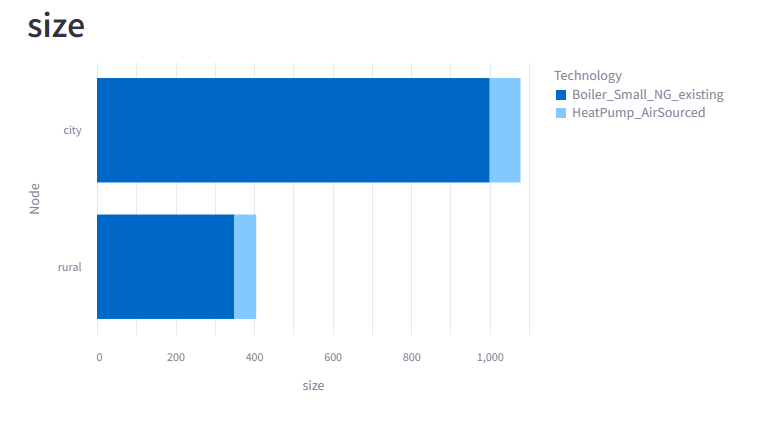

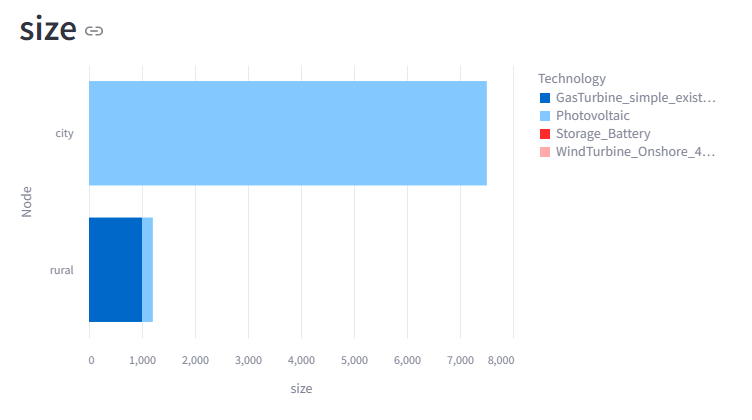



## Network operations

When the CO2 tax is included, the electricity flow changes direction and the electricity is exported from the PV "rich" city to the rural area, where the use of the gas turbine has become more expensive. Around 1.1 TWh of electricity are exported.



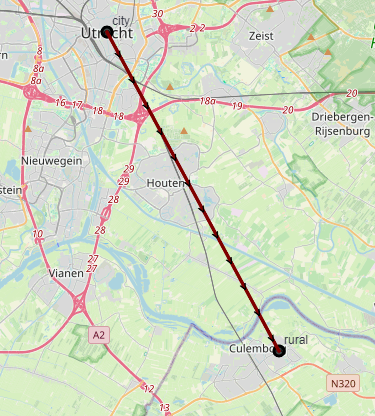